Abstract: The aim of the following code lines is to elaborate a procedure for reading and manipulating astronomical observations for a proper physical interpretation. Mainly we used long-slit spectroscpy observations taken from archives. These observations were made at ORM with the WHT using the ISIS instrument. Using python code we proceed to analyze data for different emision lines. Reduced data was provided by a previous student from the project and then prepared in txt files for this porpuse. This method proves to be a powerful tool for obtaining high quality data (eliminating low emission zones where noise is a problem and the observed spectra can't be used) that can be trusted to elaborate a physical interpretation of the problem in question. In our present research we evaluate how the correlations found in the non-thermal linewidth and radial velocity maps of an GEHR are related with the turbulence problem. We found that the structure function and the autocorrelation function correspond to a power spectra holding evidence for turbulent behaviour for all emission lines for GEHR.   

In [1]:
#Topics to future develpment:
#Physical interpretation of the observed turbulence(stellar winds,blow out,champagne)
#Sigma vs I
#Properties of the region that can be obatined from the S and R functions.

In [2]:
import numpy as np
import scipy.fftpack
from scipy import ndimage
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import os
from scipy.stats import norm
#import matplotlib.mlab as mlab
from SBR import sosf,acf,ps,sosfnorm#packagephd

#Data Load

In [3]:
input_file='datosNGC604r.txt'#astronomicalobsevations 

In [4]:
data_0=pd.read_table(input_file)#PandasDataFrameOriginalData
data=data_0.copy()#DataFrameForCalculations

In [5]:
data.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,1500.000000,1500.000000,1497.000000,1500.000000,1500.000000,1.497000e+03,1500.000000,1500.000000,1.497000e+03,1500.000000,1500.000000,1475.000000,1500.000000,1500.000000,1.475000e+03,1500.000000,1500.000000
mean,99.904500,9.390000,920.352503,-806.416087,83.475644,2.674423e+03,-834.243945,74.894615,8.020595e+03,-810.271697,74.452375,105.036422,-5215.925607,47.840685,1.958644e+12,-5241.719214,47.702254
std,58.085078,6.252917,2624.750671,13389.980282,348.636537,9.772014e+04,13388.255744,252.553948,2.930571e+05,13389.322780,251.221405,218.638500,38363.413828,281.044179,7.522315e+13,38360.054292,280.421940
min,0.000000,0.000000,-5108.000000,-299792.000000,0.000000,-6.668000e+01,-299792.000000,0.000000,-2.000000e+02,-299792.000000,0.000000,-695.300000,-299792.000000,0.000000,-6.323000e+05,-299792.000000,0.000000
25%,49.617000,4.000000,-14.620000,-277.337749,8.578435,3.071000e+00,-287.407495,10.154780,9.214000e+00,-263.109263,10.021200,2.705500,-244.585366,0.000000,1.754000e+00,-270.763708,0.000000
50%,99.904500,9.000000,47.630000,-267.002536,16.510678,6.889000e+00,-276.282044,17.402472,2.067000e+01,-252.042963,17.263627,16.630000,-232.611095,12.111469,1.180000e+01,-258.816121,12.042395
75%,150.192000,15.000000,615.400000,-152.241694,50.274305,4.467000e+01,-219.693328,74.357319,1.340000e+02,-195.755113,73.951154,119.450000,-215.057014,29.091392,8.495000e+01,-241.301160,29.009066
max,199.809000,19.600000,30960.000000,2589.901754,5770.228814,3.778000e+06,874.378072,6480.291011,1.133000e+07,892.499410,6445.836962,2329.000000,533.786887,5542.682685,2.889000e+15,505.873947,5530.330752


Here we use the Halpha line as reference to distinguish between good and bad quality data. This because in our case Halpha it is the most intense line.

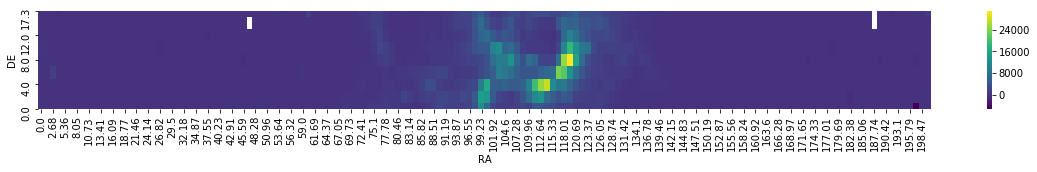

In [6]:
data_2=(data.round(2)).pivot(index='DE', columns='RA', values='Halpha')#TableFormat
fig, ax = plt.subplots(figsize=(20, 1.8))
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()

The complete 200 arcsec with the 10 observed slits (some pixel data lost). We can conclude that only the center of the slits is were the regions lies (65-145 approx arcsec for RA).

/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-9.995323248707175,
 209.80432324870722,
 -0.995007024164469,
 20.595007024164474)

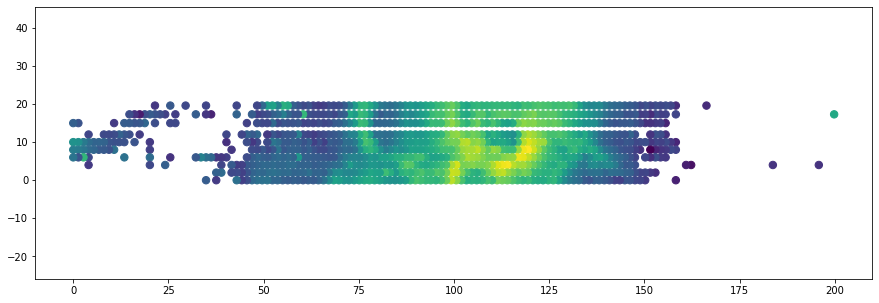

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(data.RA,data.DE,c=np.log10(data.Halpha), s=55)
plt.axis('equal')

With the logarithmic plot we get rid of negatives values giving us another insight of what positions in our observations are good to use.

Here we applpy a filter on Coordinates based on the information obtained in previous images;
between 60 arcsec and 145 arcsec in x(RA) coordinate is the range of values selected for an analysis.

In [8]:
m=(data.RA<145)&(data.RA>65)
dataH=data[m]

(61.74085558187196,
 148.79614441812808,
 -1.0150488574011365,
 20.615048857401142)

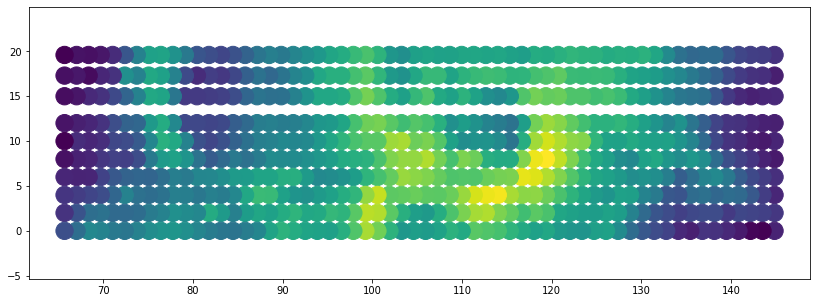

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.scatter(dataH.RA,dataH.DE,c=np.log10(dataH.Halpha), s=300)
plt.axis('equal')

In [10]:
dataH.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,105.268500,9.390000,2277.239467,-275.723172,13.935739,111.115387,-274.862061,21.256333,333.340168,-250.630529,21.078784,236.622155,-229.809584,23.307849,168.994135,-256.025456,23.203230
std,23.242952,6.256047,3750.107456,10.420076,7.810655,146.904445,31.103744,33.677958,440.691257,30.938373,33.515867,256.953154,26.830756,208.758950,201.362479,26.770974,208.297516
min,65.709000,0.000000,27.150000,-303.272854,0.000000,2.470000,-321.722417,0.000000,7.410000,-297.241741,0.000000,-25.030000,-337.288319,0.000000,-1343.000000,-363.260073,0.000000
25%,85.488750,4.000000,281.925000,-283.516037,9.420592,21.910000,-286.617726,10.253717,65.727500,-262.323693,10.120385,58.370000,-240.300072,5.044214,40.177500,-266.487964,4.931070
50%,105.268500,9.000000,1017.500000,-275.567630,12.706963,64.105000,-279.578474,13.519989,192.300000,-255.321867,13.388430,160.850000,-233.392268,10.194938,113.600000,-259.595554,10.122188
75%,125.048250,15.000000,2403.500000,-269.697685,16.901530,137.950000,-271.829574,18.615067,413.950000,-247.614166,18.472799,325.000000,-226.495624,16.456006,231.750000,-252.714278,16.388386
max,144.828000,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-8.653129,254.436545,3893.000000,14.163043,253.080612,2137.000000,45.665160,5029.368305,1568.000000,18.839996,5018.160282


We see that limiting RA values we obtain the positions where the data provides a good observations (high SN spectra) of NGC 604 in Halpha. Since data coming from the other emission lines: [NII], [SII] and [OIII] is not as bright as Halpha line the most probable sceneario is that not all data is for good use.

Histograms of the observations for all emisison lines will be used as diagnostic tools to eliminate extreme values that are not related with the physics of the HII region.

Starting with the red arm observations:

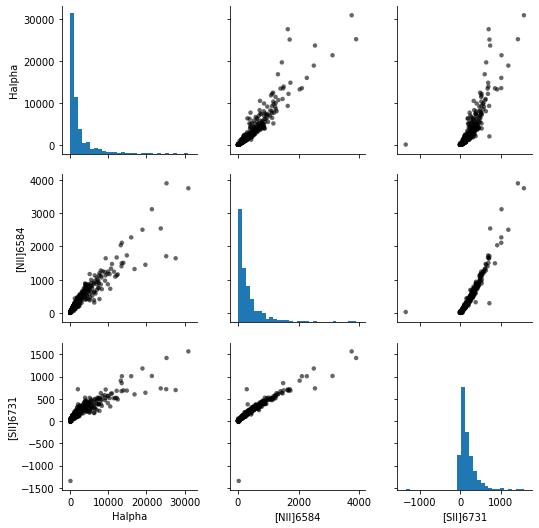

In [11]:
sns.pairplot(dataH,
             vars=["Halpha", "[NII]6584", "[SII]6731"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.6, s=20, edgecolor='none', color='k'),
             diag_kws=dict(bins=30),
            )

Adjusments will be done individually for each line.

#Halpha emission line analysis

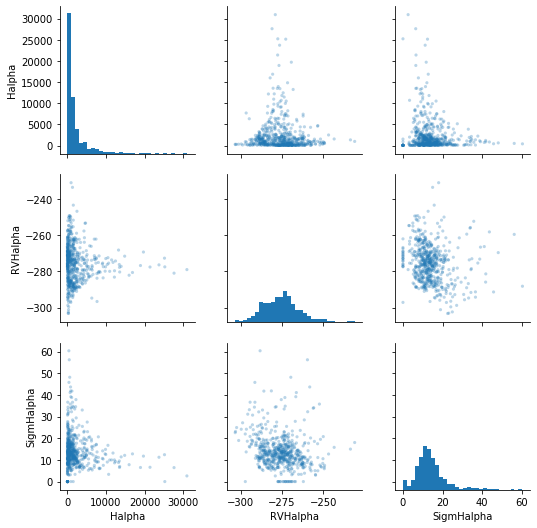

In [12]:
sns.pairplot(dataH,
             vars=["Halpha", "RVHalpha", "SigmHalpha"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

Data looks good, still sigma presents some weird values towards 0.

#Emission map

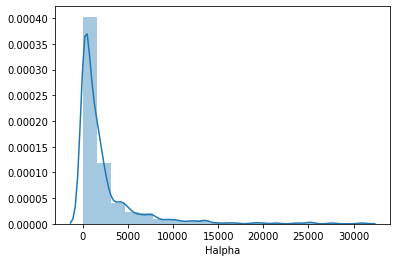

In [13]:
sns.distplot(dataH['Halpha'],bins=20)

In [14]:
dataH['Halpha'].describe()

count      600.000000
mean      2277.239467
std       3750.107456
min         27.150000
25%        281.925000
50%       1017.500000
75%       2403.500000
max      30960.000000
Name: Halpha, dtype: float64

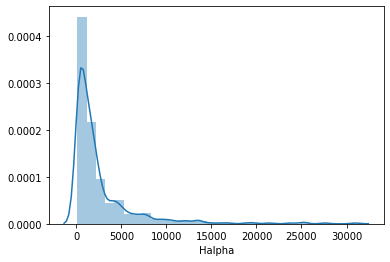

In [15]:
mhf0=(dataH.Halpha<35000)&(dataH.Halpha>100)
sns.distplot(dataH[mhf0]['Halpha'],bins=30)

In [16]:
dataH['Halpha'][mhf0].describe()

count      522.000000
mean      2608.155556
std       3914.681434
min        101.400000
25%        505.050000
50%       1355.000000
75%       2691.000000
max      30960.000000
Name: Halpha, dtype: float64

(61.80848384917406, 147.38751615082592, -0.9978857951459071, 20.59788579514591)

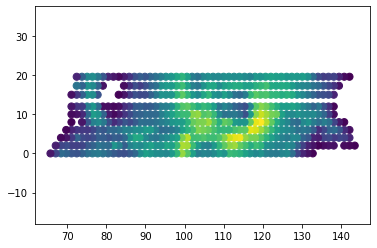

In [17]:
plt.scatter(dataH[mhf0].RA,dataH[mhf0].DE,c=np.log10(dataH.Halpha[mhf0]), s=50)
plt.axis('equal')

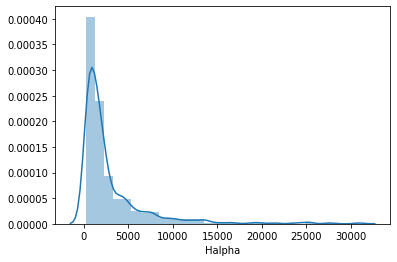

In [18]:
mhf1=(dataH.Halpha<35000)&(dataH.Halpha>250)
sns.distplot(dataH[mhf1]['Halpha'],bins=30)

(63.35063384917405, 144.50436615082594, -0.9978857951459071, 20.59788579514591)

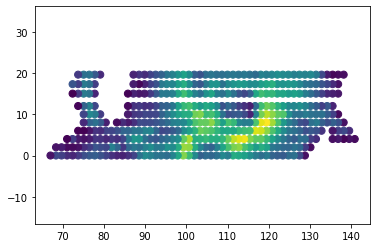

In [19]:
plt.scatter(dataH[mhf1].RA,dataH[mhf1].DE,c=np.log10(dataH[mhf1].Halpha), s=50)
plt.axis('equal')

In [20]:
dataH=dataH[mhf1]

In [21]:
datal=dataH.copy()
datal.Halpha=np.log10(datal.Halpha)
dataH_f=(datal.round(2)).pivot(index='DE', columns='RA', values='Halpha')

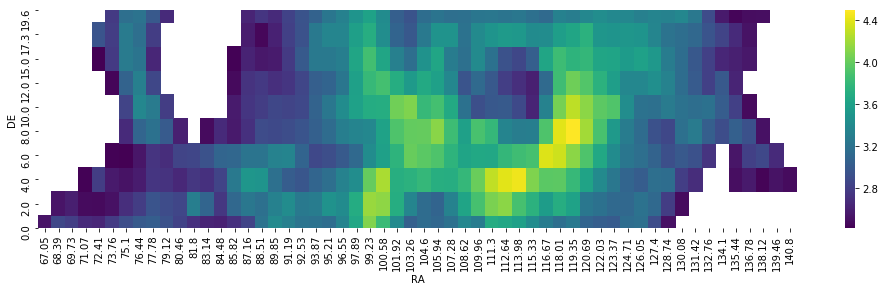

In [22]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(dataH_f, cmap="viridis")
plt.gca().invert_yaxis()

The Emission maps reproduce the HII region, data worked in this case. Lets see, how the other maps behave:

#Radial velocity map

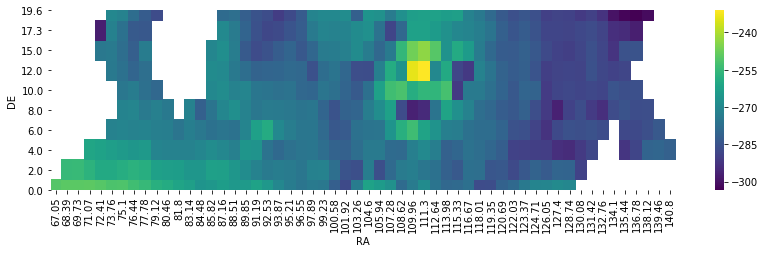

In [23]:
dataH_rv=(dataH.round(2)).pivot(index='DE', columns='RA', values='RVHalpha')
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

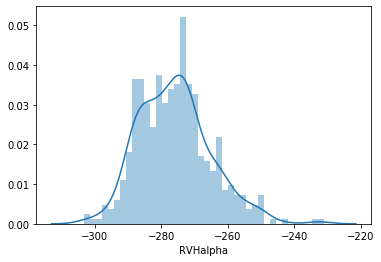

In [24]:
sns.distplot(dataH.RVHalpha,bins=40)

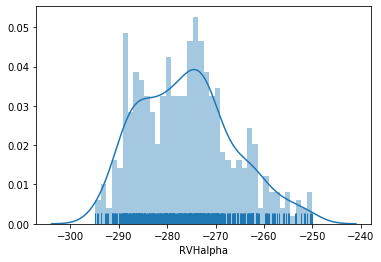

In [25]:
mhrv=(dataH.RVHalpha<-250)&(dataH.RVHalpha>-295)
sns.distplot(dataH[mhrv]['RVHalpha'],bins=40,rug=True)

In [26]:
dataH[mhrv].RVHalpha.describe()

count    442.000000
mean    -276.037663
std        9.642408
min     -294.776281
25%     -283.767280
50%     -276.184316
75%     -270.348632
max     -250.100750
Name: RVHalpha, dtype: float64

In [152]:
#(mu,sigma)=norm.fit(dataH[mhrv]['RVHalpha'])
#n, bins, patches = plt.hist(dataH[mhrv]['RVHalpha'], 40, normed=1, facecolor='red', alpha=0.75)
#y = scipy.stats.norm.pdf(bins, mu, sigma)
#l = plt.plot(bins, y, 'b-', linewidth=2)
#plt.title(r'$\mathrm{Histogram}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
#plt.grid(True)
#FROM:https://stackoverflow.com/questions/7805552/fitting-a-histogram-with-python

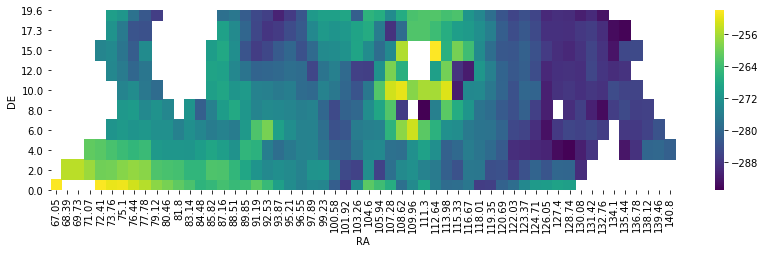

In [28]:
dataH_rv=(dataH[mhrv].round(2)).pivot(index='DE', columns='RA', values='RVHalpha')
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

Data arragement for statistical analysis

In [29]:
a=[dataH.RA,dataH.DE,dataH.RVHalpha]
dataHstat=pd.DataFrame(a).T
dataHstat.columns=['X','Y','RV']
dataHstat.describe()

,X,Y,RV
count,457.000000,457.000000,457.000000
mean,105.302245,9.121007,-275.943619
std,18.791842,6.243842,10.800827
min,67.050000,0.000000,-303.272854
25%,89.847000,4.000000,-284.041363
50%,105.939000,8.000000,-276.229997
75%,120.690000,15.000000,-270.063129
max,140.805000,19.600000,-231.143341


#Statistical Analysis

Strcuture Function

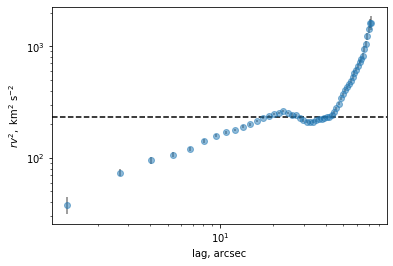

In [30]:
sf_h=sosf(dataHstat)

Normalized Strcuture Function

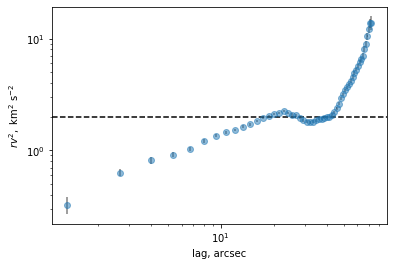

In [31]:
sfn_h=sosfnorm(dataHstat)

Autocorrelation Function

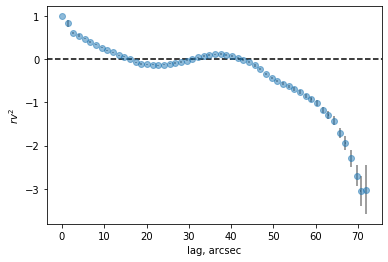

In [32]:
ac_h=acf(dataHstat)

#Veocity profiles

Elimnate large scale (LS) movements. Scale comparable to the size of the region.

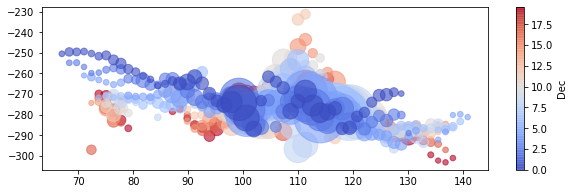

In [33]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataH.RA, dataH.RVHalpha, c=dataH.DE, s=dataH.Halpha*0.1, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
#ax.set(xlim=[65.0, 145.0])

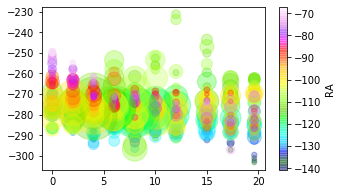

In [34]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(dataH.DE, dataH.RVHalpha, c=-dataH.RA, s=dataH.Halpha*0.08, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")



Fit a cubic function to V(Ha) vs RA to try and remove the large-scale trend.


In [35]:
pRA = np.poly1d(np.polyfit(dataH.RA, dataH.RVHalpha, 3))
print(pRA)

            3          2
-0.0003916 x + 0.1179 x - 11.85 x + 123.7


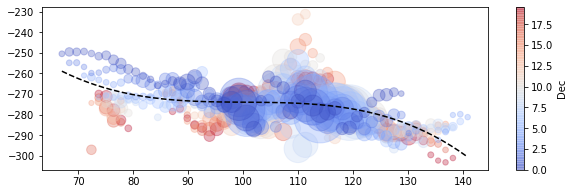

In [36]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataH.RA, dataH.RVHalpha, c=dataH.DE, s=dataH.Halpha*0.1, alpha=0.3, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
RAgrid = np.linspace(dataH.RA.min(), dataH.RA.max())
ax.plot(RAgrid, pRA(RAgrid), c="k", ls="--")

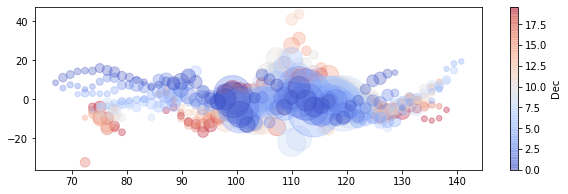

In [37]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataH.RA, dataH.RVHalpha - pRA(dataH.RA), c=dataH.DE, s=dataH.Halpha*0.1, alpha=0.3, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")

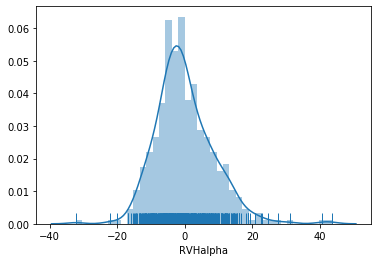

In [38]:
hist=dataH.RVHalpha - pRA(dataH.RA)
sns.distplot(hist,bins=40,rug=True)

In [39]:
df1 = pd.DataFrame({'X': dataH.RA, 'Y': dataH.DE, 'RV': dataH.RVHalpha - pRA(dataH.RA)})
df1.describe()

,X,Y,RV
count,457.000000,457.000000,4.570000e+02
mean,105.302245,9.121007,-9.508523e-13
std,18.791842,6.243842,8.655304e+00
min,67.050000,0.000000,-3.223237e+01
25%,89.847000,4.000000,-5.451067e+00
50%,105.939000,8.000000,-1.017147e+00
75%,120.690000,15.000000,4.916619e+00
max,140.805000,19.600000,4.356079e+01


Statistical analysis detrended data

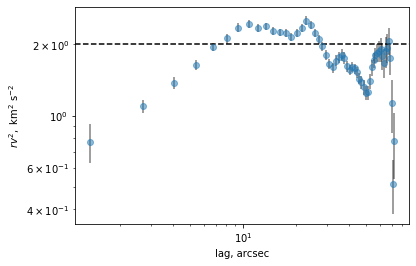

In [175]:
sfn_h2=sosfnorm(df1)

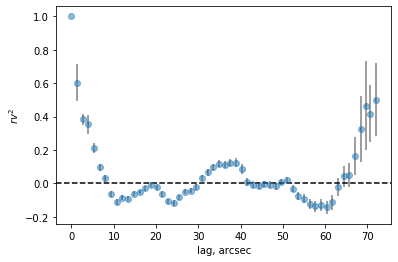

In [41]:
ac_h2=acf(df1)

IMPORTANT: Since the image has missing data the FFT can not be performed.
To resolve this issue we filter again raw data.

#Central region analysis

In this case we filter the data between 85 and 125 arcsec, this to avoid in a natural way large scale trends and guarantee an homogenous data on the velocity field. This procedure will help us compare reults with Medina Tanco et al. (1996) since the have done a similar thing but with Fabry-Perto observations.

In [42]:
mHH=(data_0.RA<125)&(data_0.RA>85)
dataHH=data_0[mHH]
dataHH.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,300.00000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,105.26850,9.390000,3998.446333,-274.647015,15.292496,183.149033,-278.081651,15.021794,549.438233,-253.833001,14.873523,377.084900,-231.909824,28.639368,275.529467,-258.121164,28.516452
std,11.62634,6.261276,4669.020580,9.243500,8.539326,176.424696,10.287413,7.898948,529.241090,10.232718,7.885000,287.426399,10.565181,289.840548,216.441297,10.540990,289.198918
min,85.82400,0.000000,226.000000,-296.649181,0.000000,15.370000,-315.358475,0.999554,46.110000,-290.911635,0.000000,54.080000,-271.982230,0.000000,31.460000,-298.099518,0.000000
25%,95.21100,4.000000,1289.750000,-280.900828,9.988411,73.047500,-284.546011,10.253717,219.125000,-260.262993,10.120385,180.150000,-238.436416,5.614076,128.700000,-264.628461,5.510188
50%,105.26850,9.000000,2300.000000,-275.362067,13.445320,131.100000,-279.143528,12.949410,393.250000,-254.889233,12.818243,305.550000,-233.035160,10.228748,215.800000,-259.239242,10.156088
75%,115.32600,15.000000,4924.750000,-269.766206,17.476963,239.825000,-272.550668,17.307156,719.575000,-248.331426,17.168562,485.425000,-226.495624,15.767300,361.250000,-252.714278,15.699860
max,124.71300,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-231.162158,60.686803,3893.000000,-207.162966,60.350881,2137.000000,-193.730983,5029.368305,1568.000000,-220.022653,5018.160282


In [43]:
a=[dataHH.RA,dataHH.DE,dataHH['RVHalpha']]
dataHHstat=pd.DataFrame(a).T
dataHHstat.columns=['X','Y','RV']
dataHHstat.describe()

,X,Y,RV
count,300.00000,300.000000,300.000000
mean,105.26850,9.390000,-274.647015
std,11.62634,6.261276,9.243500
min,85.82400,0.000000,-296.649181
25%,95.21100,4.000000,-280.900828
50%,105.26850,9.000000,-275.362067
75%,115.32600,15.000000,-269.766206
max,124.71300,19.600000,-231.143341


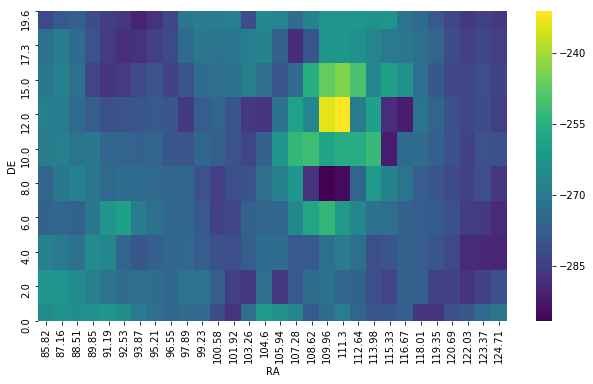

In [44]:
dataHH_rv=(dataHH.round(2)).pivot(index='DE', columns='RA', values='RVHalpha')
fig, ax = plt.subplots(figsize=(10.5, 5.7))
sns.heatmap(dataHH_rv, cmap="viridis")
plt.gca().invert_yaxis()

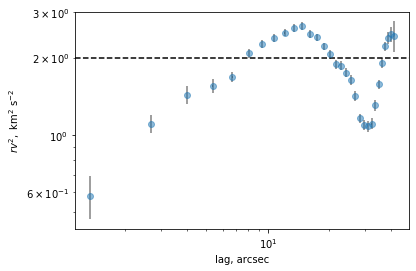

In [45]:
sfn_h3=sosfnorm(dataHHstat)

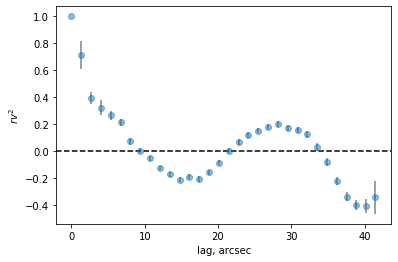

In [46]:
af_h3=acf(dataHHstat)

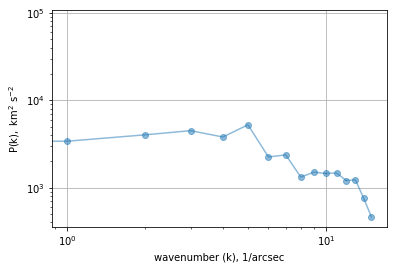

In [47]:
ps_h3=ps(dataHHstat)

[Text(0, 0.5, 'R(l),S(l)'), Text(0.5, 0, 'lag, arcsec')]

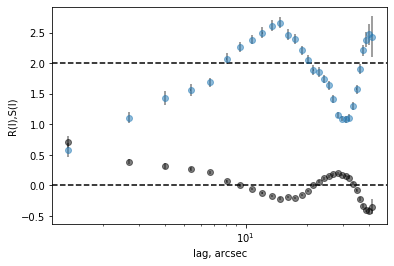

In [49]:
fig, ax=plt.subplots()
ax.errorbar(sfn_h3['Lag'],sfn_h3['Nmqvd'],xerr=sfn_h3.ErrX,yerr=sfn_h3.ErrY, fmt="o", ecolor='k', alpha=0.5)
ax.set(xscale='log')
ax.axhline(y=2, color='k', linestyle='--')
ax.errorbar(af_h3['Lag pc'],af_h3['Nmqvd'],xerr=af_h3.ErrX,yerr=af_h3.ErrY, fmt="o", color='k', ecolor='k', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l),S(l)')
#sgrid = np.logspace(.08, 1.35)
#ax.plot(sgrid, 38.0*sgrid**(2/3), color="k", lw=0.8)

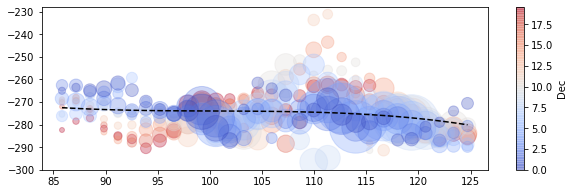

In [50]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataHH.RA, dataHH.RVHalpha, c=dataHH.DE, s=dataHH.Halpha*0.1, alpha=0.3, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
RAgrid = np.linspace(dataHH.RA.min(), dataHH.RA.max())
ax.plot(RAgrid, pRA(RAgrid), c="k", ls="--")

We can se that it is not necessary to do a fit since large scale movementes arent been consider en in the obsevartional region.

Energy Stuff

In [51]:
((dataHHstat.RV)**2).mean()

75516.14049680202

#Sigma map

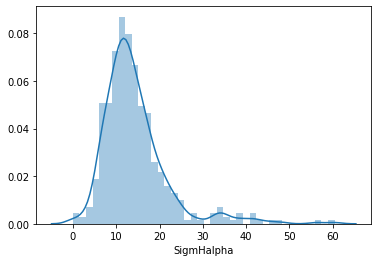

In [52]:
sns.distplot(dataH.SigmHalpha,bins=40)

In [53]:
dataH.SigmHalpha.describe()

count    457.000000
mean      14.313232
std        7.686761
min        0.000000
25%        9.771442
50%       12.813973
75%       16.894942
max       60.414211
Name: SigmHalpha, dtype: float64

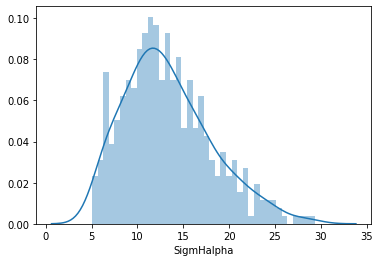

In [54]:
mhs=(dataH.SigmHalpha<30)&(dataH.SigmHalpha>5)
sns.distplot(dataH[mhs]['SigmHalpha'],bins=40)

In [55]:
dataH[mhs].SigmHalpha.describe()

count    424.000000
mean      13.308606
std        4.798419
min        5.047297
25%        9.916463
50%       12.676292
75%       16.202916
max       29.403568
Name: SigmHalpha, dtype: float64

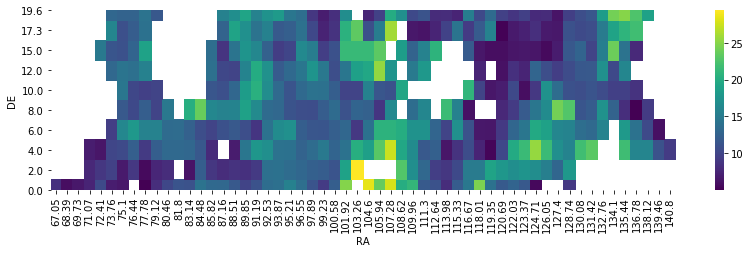

In [56]:
dataH_s=(dataH[mhs].round(2)).pivot(index='DE', columns='RA', values='SigmHalpha')
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_s, cmap="viridis")
plt.gca().invert_yaxis()

I vs Sigma diagnostic diagram

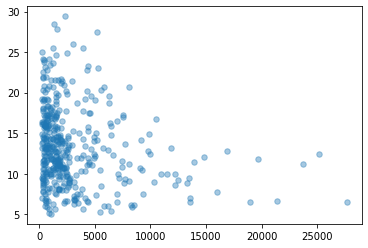

In [57]:
plt.scatter(dataH[mhs].Halpha,dataH[mhs].SigmHalpha, alpha=0.4, s=30)

#[NII] 6585 emission line

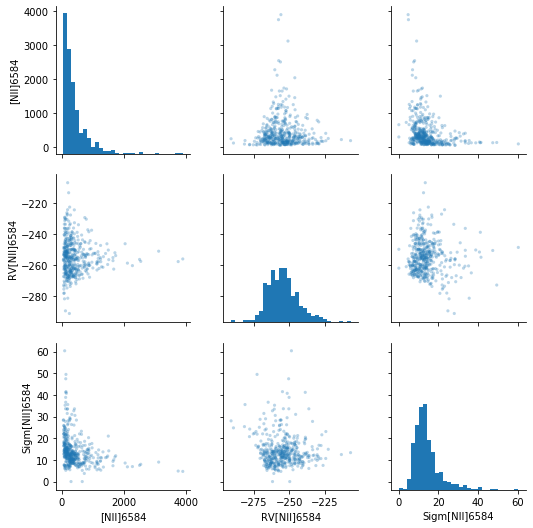

In [58]:
dataN_0=dataH.copy()
dataN=dataH.copy()
sns.pairplot(dataN_0,
             vars=["[NII]6584", "RV[NII]6584", "Sigm[NII]6584"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

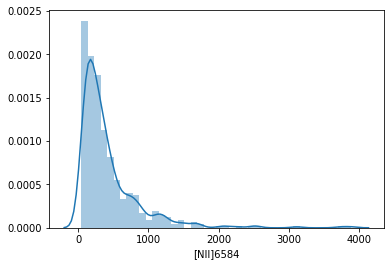

In [59]:
sns.distplot(dataN['[NII]6584'])

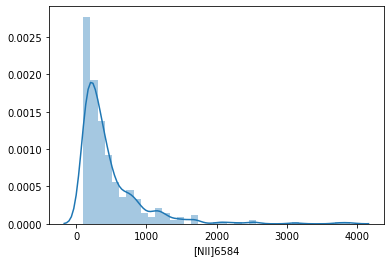

In [60]:
mnf=(dataN['[NII]6584']<4000)&(dataN['[NII]6584']>100)
sns.distplot(dataN[mnf]['[NII]6584'])

In [61]:
dataN=dataN[mnf]

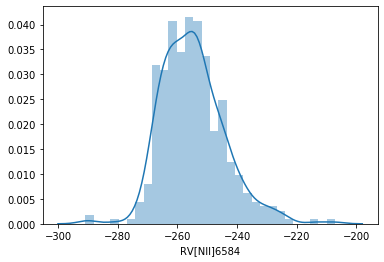

In [62]:
sns.distplot(dataN['RV[NII]6584'], bins=30)

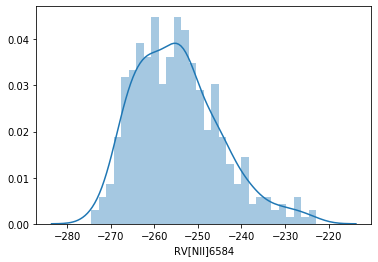

In [63]:
mnrv=(dataN['RV[NII]6584']>-280)&(dataN['RV[NII]6584']<-220)
sns.distplot(dataN[mnrv]['RV[NII]6584'], bins=30)

In [64]:
dataN=dataN[mnrv]

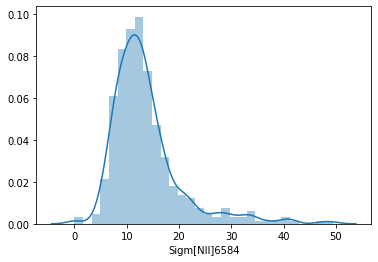

In [65]:
sns.distplot(dataN['Sigm[NII]6584'])

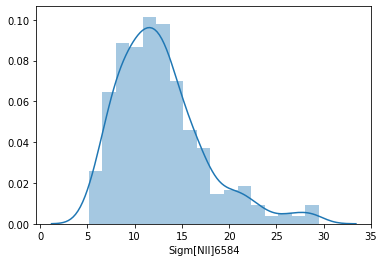

In [66]:
mns=(dataN['Sigm[NII]6584']>5)&(dataN['Sigm[NII]6584']<30)
sns.distplot(dataN[mns]['Sigm[NII]6584'])

In [67]:
dataN=dataN[mns]

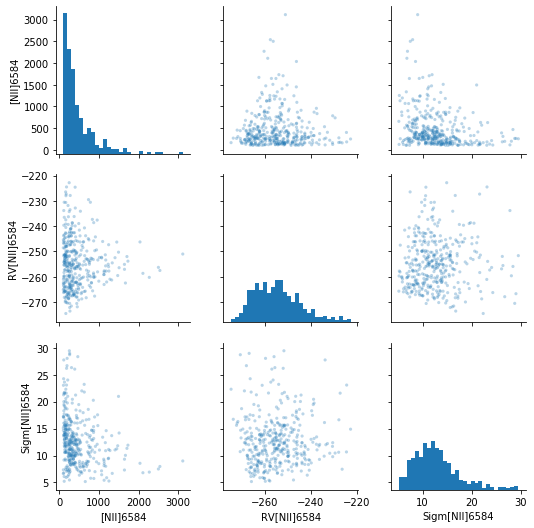

In [68]:
sns.pairplot(dataN,
             vars=["[NII]6584", "RV[NII]6584", "Sigm[NII]6584"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

In [69]:
dataNl=dataN.copy()
dataNl.Halpha=np.log10(data['[NII]6584'])
dataN_f=(dataN.round(2)).pivot(index='DE', columns='RA', values='[NII]6584')
dataN_rv=(dataN.round(2)).pivot(index='DE', columns='RA', values='RV[NII]6584')
dataN_s=(dataN.round(2)).pivot(index='DE', columns='RA', values='Sigm[NII]6584')

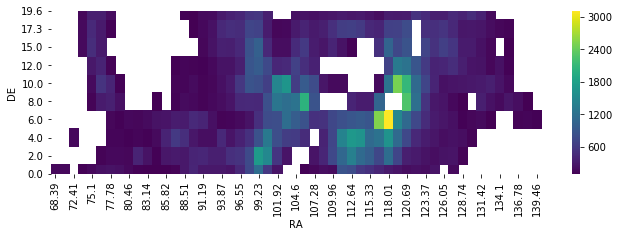

In [70]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_f, cmap="viridis")
plt.gca().invert_yaxis()

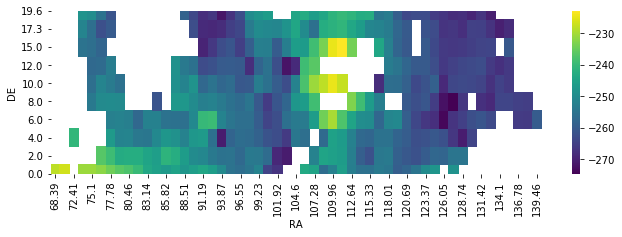

In [71]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_rv, cmap="viridis")
plt.gca().invert_yaxis()


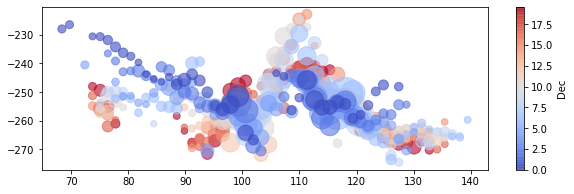

In [72]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataN.RA, dataN['RV[NII]6584'], c=dataN.DE, s=dataN['[NII]6584']*0.4, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")

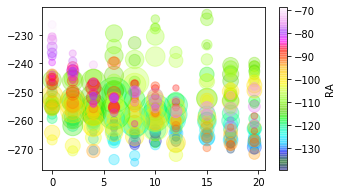

In [73]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(dataN.DE, dataN['RV[NII]6584'], c=-dataN.RA, s=dataN['[NII]6584']*0.4, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")

In [74]:
a=[dataN.RA,dataN.DE,dataN['RV[NII]6584']]
dataNstat=pd.DataFrame(a).T
dataNstat.columns=['X','Y','RV']
dataNstat.describe()

,X,Y,RV
count,379.000000,379.000000,379.000000
mean,105.769164,9.087071,-254.720650
std,17.526613,6.242012,9.887710
min,68.391000,0.000000,-274.562657
25%,92.529000,4.000000,-262.312308
50%,105.939000,8.000000,-255.390177
75%,120.690000,15.000000,-249.037301
max,139.464000,19.600000,-222.783300


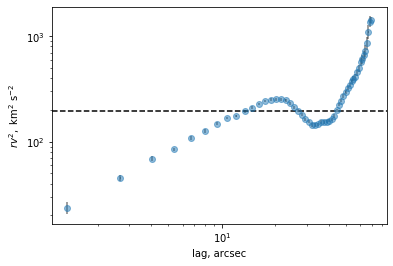

In [75]:
sf_n=sosf(dataNstat)

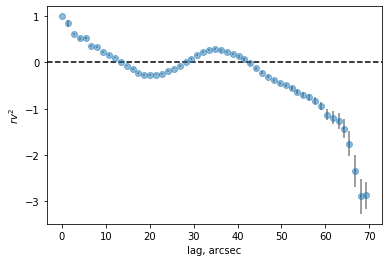

In [76]:
af_n=acf(dataNstat)

Since the image has missing data the FFT can not be performed.
To resolve this issue we filter again raw data but just for [NII].

In [77]:
mNN=(data_0.RA<125)&(data_0.RA>90)
dataNN=data_0[mNN]
dataNN.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,107.950500,9.390000,4462.242308,-275.149302,15.663124,201.258077,-278.401656,14.938647,603.764000,-254.151305,14.788877,408.148654,-232.172951,31.242521,299.310692,-258.383236,31.112336
std,10.076897,6.262888,4842.478368,9.606268,9.003773,182.028182,10.797795,8.327424,546.048701,10.740386,8.312576,293.809144,11.091419,311.331492,221.288690,11.066194,310.642340
min,91.188000,0.000000,401.400000,-296.649181,0.000000,27.770000,-315.358475,0.999554,83.300000,-290.911635,0.000000,65.180000,-271.982230,0.000000,43.930000,-298.099518,0.000000
25%,99.234000,4.000000,1514.000000,-281.448994,10.042098,85.150000,-284.843605,9.846227,255.450000,-260.559005,9.711760,202.850000,-239.050195,5.292281,147.350000,-265.240872,5.183417
50%,107.950500,9.000000,2611.500000,-275.933074,13.534091,143.800000,-279.509798,12.625755,431.500000,-255.253556,12.494704,335.650000,-234.218080,9.990155,240.150000,-260.419525,9.916830
75%,116.667000,15.000000,5471.000000,-271.285083,17.851654,255.125000,-273.706708,16.791739,765.475000,-249.481319,16.654450,517.400000,-226.227793,15.944005,388.025000,-252.447044,15.876529
max,124.713000,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-231.162158,60.686803,3893.000000,-207.162966,60.350881,2137.000000,-193.730983,5029.368305,1568.000000,-220.022653,5018.160282


In [78]:
a=[dataNN.RA,dataNN.DE,dataNN['RV[NII]6584']]
dataNNstat=pd.DataFrame(a).T
dataNNstat.columns=['X','Y','RV']
dataNNstat.describe()

,X,Y,RV
count,260.000000,260.000000,260.000000
mean,107.950500,9.390000,-254.151305
std,10.076897,6.262888,10.740386
min,91.188000,0.000000,-290.911635
25%,99.234000,4.000000,-260.559005
50%,107.950500,9.000000,-255.253556
75%,116.667000,15.000000,-249.481319
max,124.713000,19.600000,-207.162966


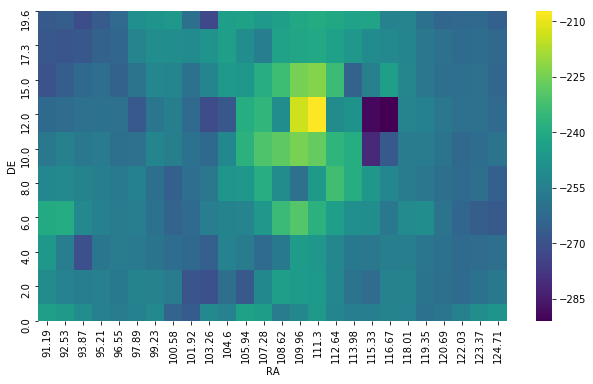

In [79]:
dataNN_rv=(dataNN.round(2)).pivot(index='DE', columns='RA', values='RV[NII]6584')
fig, ax = plt.subplots(figsize=(10.5, 5.7))
sns.heatmap(dataNN_rv, cmap="viridis")
plt.gca().invert_yaxis()
#plt.axis('equal')

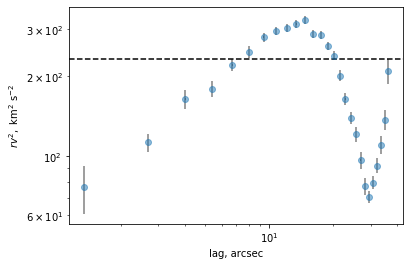

In [80]:
sf_n2=sosf(dataNNstat)

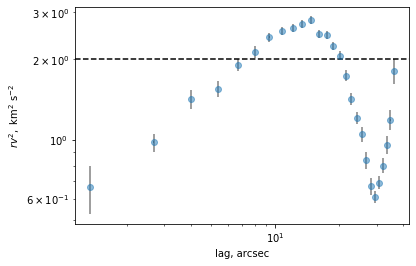

In [81]:
sfn_n2=sosfnorm(dataNNstat)

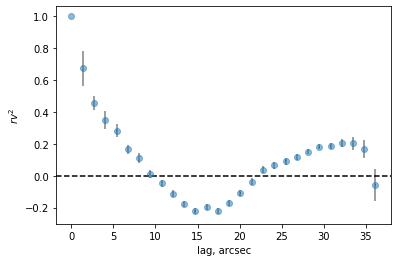

In [82]:
af_n2=acf(dataNNstat)

[Text(0, 0.5, 'R(l),S(l)'), Text(0.5, 0, 'lag, arcsec')]

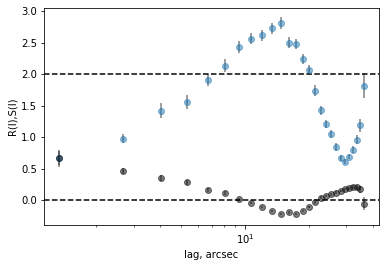

In [83]:
fig, ax=plt.subplots()
ax.errorbar(sfn_n2['Lag'],sfn_n2['Nmqvd'],xerr=sfn_n2.ErrX,yerr=sfn_n2.ErrY, fmt="o", ecolor='k', alpha=0.5)
ax.set(xscale='log')
ax.axhline(y=2, color='k', linestyle='--')
ax.errorbar(af_n2['Lag pc'],af_n2['Nmqvd'],xerr=af_n2.ErrX,yerr=af_n2.ErrY, fmt="o", color='k', ecolor='k', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l),S(l)')

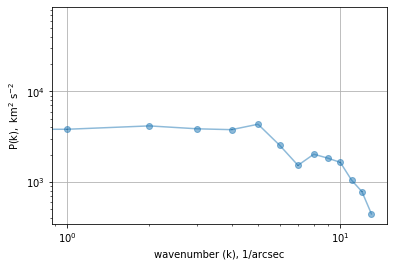

In [84]:
ps_n2=ps(dataNNstat)

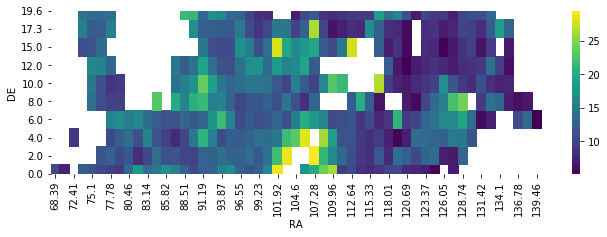

In [85]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_s, cmap="viridis")
plt.gca().invert_yaxis()

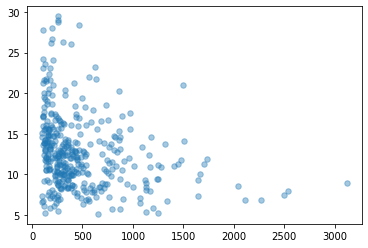

In [86]:
plt.scatter(dataN['[NII]6584'],dataN['Sigm[NII]6584'], alpha=0.4, s=30)

#[SII] 6731 emission line

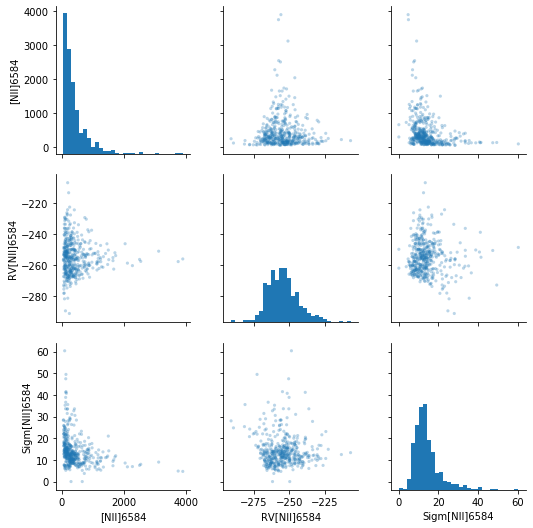

In [87]:
dataS_0=dataH.copy()
dataS=dataH.copy()
sns.pairplot(dataS_0,
             vars=["[NII]6584", "RV[NII]6584", "Sigm[NII]6584"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

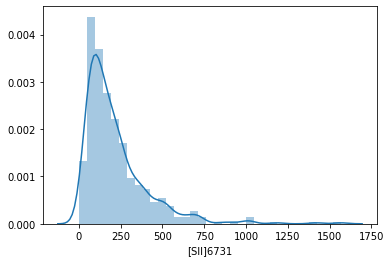

In [88]:
sns.distplot(dataS_0['[SII]6731'])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


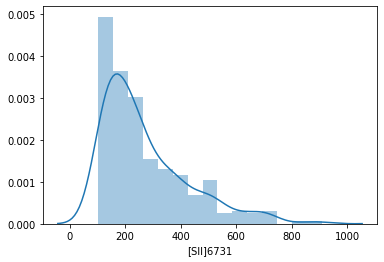

In [89]:
msf=(dataS['[SII]6731']<1000)&(dataN['[SII]6731']>100)
sns.distplot(dataN[msf]['[SII]6731'])

In [90]:
dataS=dataS[msf]

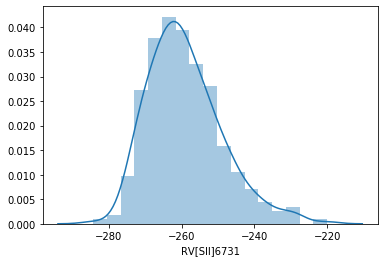

In [91]:
sns.distplot(dataS['RV[SII]6731'])

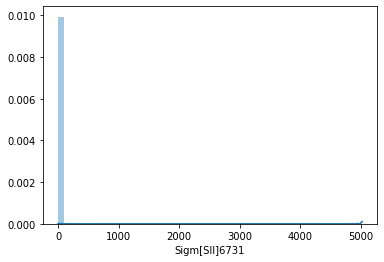

In [92]:
sns.distplot(dataS['Sigm[SII]6731'])

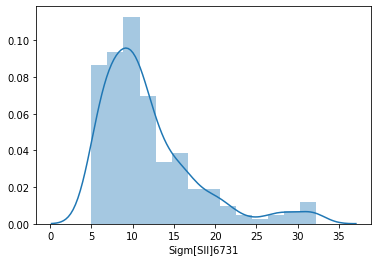

In [93]:
mss=(dataS['Sigm[SII]6731']>5)&(dataS['Sigm[SII]6731']<50)
sns.distplot(dataS[mss]['Sigm[SII]6731'])

In [94]:
dataS=dataS[mss]

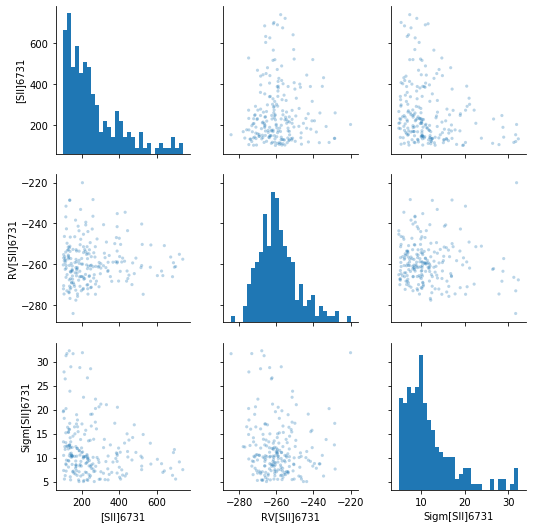

In [95]:
sns.pairplot(dataS,
             vars=["[SII]6731", "RV[SII]6731", "Sigm[SII]6731"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

In [96]:
dataSl=data.copy()
dataSl.Halpha=np.log10(data['[SII]6731'])
dataS_f=(dataS.round(2)).pivot(index='DE', columns='RA', values='[SII]6731')
dataS_rv=(dataS.round(2)).pivot(index='DE', columns='RA', values='RV[SII]6731')
dataS_s=(dataS.round(2)).pivot(index='DE', columns='RA', values='Sigm[SII]6731')

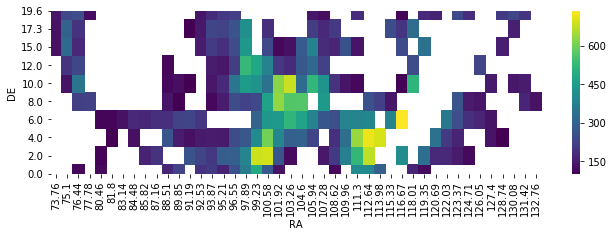

In [97]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataS_f, cmap="viridis")
plt.gca().invert_yaxis()

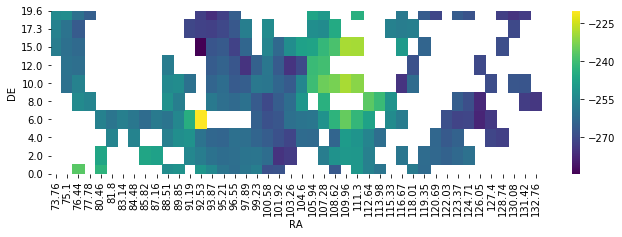

In [98]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataS_rv, cmap="viridis")
plt.gca().invert_yaxis()

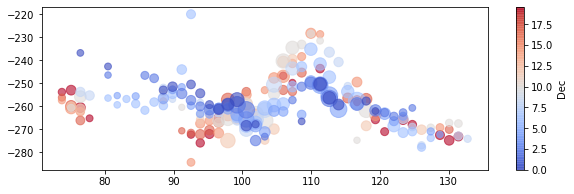

In [99]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataS.RA, dataS['RV[SII]6731'], c=dataS.DE, s=dataS['[SII]6731']*0.4, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")

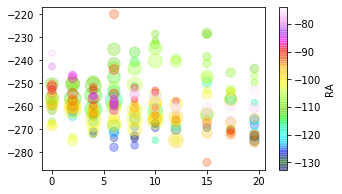

In [100]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(dataS.DE, dataS['RV[SII]6731'], c=-dataS.RA, s=dataS['[SII]6731']*0.4, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")

In [101]:
a=[dataS.RA,dataS.DE,dataS['RV[SII]6731']]
dataSstat=pd.DataFrame(a).T
dataSstat.columns=['X','Y','RV']
dataSstat.describe()

,X,Y,RV
count,214.000000,214.000000,214.000000
mean,102.761958,8.852804,-259.000521
std,14.581423,6.030958,10.522173
min,73.755000,0.000000,-284.292429
25%,93.870000,4.000000,-266.120517
50%,101.916000,8.000000,-260.419525
75%,112.644000,15.000000,-253.671867
max,132.759000,19.600000,-220.022653


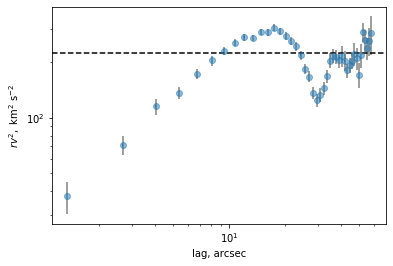

In [102]:
sf_s=sosf(dataSstat)

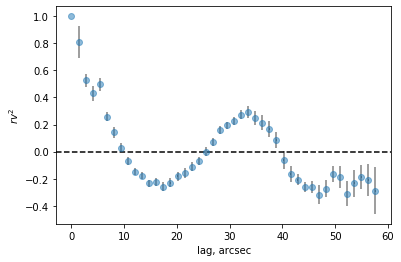

In [103]:
af_s=acf(dataSstat)

Since the image has missing data the FFT can not be performed.
To resolve this issue we filter again raw data but just for [SII]

In [104]:
ms=(data_0.RA<125)&(data_0.RA>90)
dataS2=data_0[ms]
dataS2.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,107.950500,9.390000,4462.242308,-275.149302,15.663124,201.258077,-278.401656,14.938647,603.764000,-254.151305,14.788877,408.148654,-232.172951,31.242521,299.310692,-258.383236,31.112336
std,10.076897,6.262888,4842.478368,9.606268,9.003773,182.028182,10.797795,8.327424,546.048701,10.740386,8.312576,293.809144,11.091419,311.331492,221.288690,11.066194,310.642340
min,91.188000,0.000000,401.400000,-296.649181,0.000000,27.770000,-315.358475,0.999554,83.300000,-290.911635,0.000000,65.180000,-271.982230,0.000000,43.930000,-298.099518,0.000000
25%,99.234000,4.000000,1514.000000,-281.448994,10.042098,85.150000,-284.843605,9.846227,255.450000,-260.559005,9.711760,202.850000,-239.050195,5.292281,147.350000,-265.240872,5.183417
50%,107.950500,9.000000,2611.500000,-275.933074,13.534091,143.800000,-279.509798,12.625755,431.500000,-255.253556,12.494704,335.650000,-234.218080,9.990155,240.150000,-260.419525,9.916830
75%,116.667000,15.000000,5471.000000,-271.285083,17.851654,255.125000,-273.706708,16.791739,765.475000,-249.481319,16.654450,517.400000,-226.227793,15.944005,388.025000,-252.447044,15.876529
max,124.713000,19.600000,30960.000000,-231.143341,60.414211,1298.000000,-231.162158,60.686803,3893.000000,-207.162966,60.350881,2137.000000,-193.730983,5029.368305,1568.000000,-220.022653,5018.160282


In [105]:
a=[dataS2.RA,dataS2.DE,dataS2['RV[SII]6731']]
dataS2stat=pd.DataFrame(a).T
dataS2stat.columns=['X','Y','RV']
dataS2stat.describe()

,X,Y,RV
count,260.000000,260.000000,260.000000
mean,107.950500,9.390000,-258.383236
std,10.076897,6.262888,11.066194
min,91.188000,0.000000,-298.099518
25%,99.234000,4.000000,-265.240872
50%,107.950500,9.000000,-260.419525
75%,116.667000,15.000000,-252.447044
max,124.713000,19.600000,-220.022653


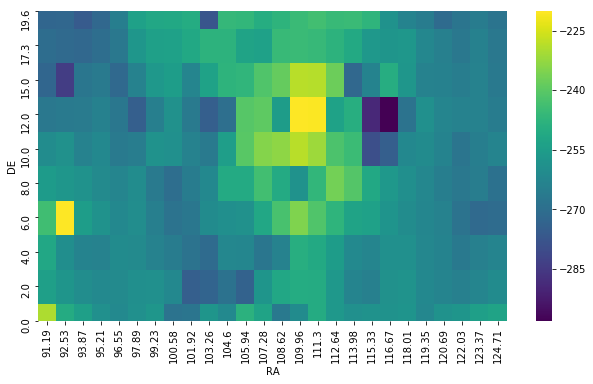

In [106]:
dataS2_rv=(dataS2.round(2)).pivot(index='DE', columns='RA', values='RV[SII]6731')
fig, ax = plt.subplots(figsize=(10.5, 5.7))
sns.heatmap(dataS2_rv, cmap="viridis")
plt.gca().invert_yaxis()
#plt.axis('equal')

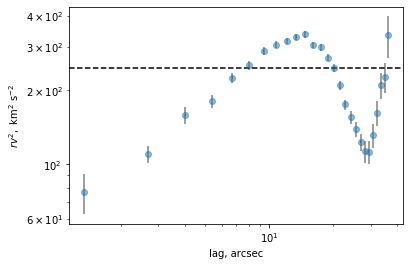

In [107]:
sf_s2=sosf(dataS2stat)

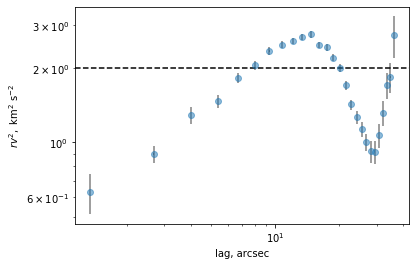

In [108]:
sfn_s2=sosfnorm(dataS2stat)

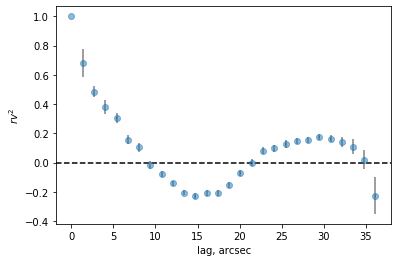

In [109]:
af_s2=acf(dataS2stat)

[Text(0, 0.5, 'R(l),S(l)'), Text(0.5, 0, 'lag, arcsec')]

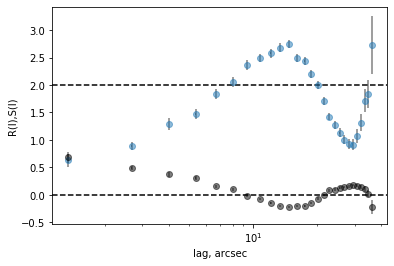

In [110]:
fig, ax=plt.subplots()
ax.errorbar(sfn_s2['Lag'],sfn_s2['Nmqvd'],xerr=sfn_s2.ErrX,yerr=sfn_s2.ErrY, fmt="o", ecolor='k', alpha=0.5)
ax.set(xscale='log')
ax.axhline(y=2, color='k', linestyle='--')
ax.errorbar(af_s2['Lag pc'],af_s2['Nmqvd'],xerr=af_s2.ErrX,yerr=af_s2.ErrY, fmt="o", color='k', ecolor='k', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l),S(l)')


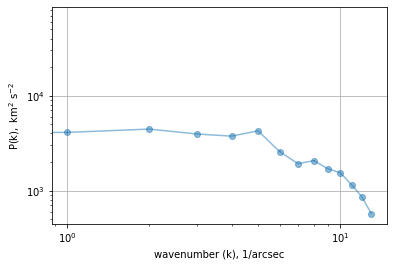

In [111]:
ps_s2=ps(dataS2stat)

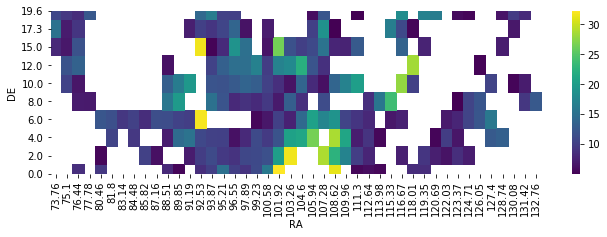

In [112]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataS_s, cmap="viridis")
plt.gca().invert_yaxis()

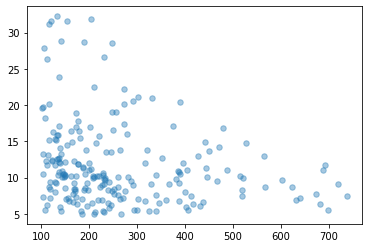

In [113]:
plt.scatter(dataS['[SII]6731'],dataS['Sigm[SII]6731'], alpha=0.4, s=30)

Electron density

In [114]:
def eden(R):
    """Approximate sii electron density from R=6717/6731"""
    RR = 1.0/R
    return 2489*(RR - 0.6971) / (2.3380 - RR)

In [115]:
fSii1=dataS['[SII]6717']
vSii1=dataS['RV[SII]6717']
sSii1=dataS['Sigm[SII]6717']

fSii2=dataS['[SII]6731']
vSii2=dataS['RV[SII]6731']
sSii2=dataS['Sigm[SII]6731']

In [116]:
dfSii = pd.DataFrame(
    {'log_F': np.log10(fSii1 + fSii2), 
     'R12': fSii1/fSii2,
     'dV12': vSii1 - vSii2, 
     'V': (fSii1*vSii1 + fSii2*vSii2)/(fSii1 + fSii2),
     'sigma': np.sqrt((fSii1*sSii1**2 + fSii2*sSii2**2)/(fSii1 + fSii2)),
     'sigma12': sSii1/sSii2,
     'RA': dataS.RA,
     'DE': dataS.DE,
     'Ed':eden(fSii1/fSii2),
    }
)

In [117]:
dfSii.describe()

,log_F,R12,dV12,V,sigma,sigma12,RA,DE,Ed
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2.734343,1.390634,26.209204,-243.778832,11.839727,1.008349,102.761958,8.852804,58.768873
std,0.216631,0.103581,0.027256,10.492843,5.814361,0.004665,14.581423,6.030958,311.037911
min,2.379849,0.573674,26.148126,-272.328993,5.071862,1.002723,73.755000,0.000000,-173.125668
25%,2.547620,1.343600,26.189831,-250.777784,7.829206,1.004908,93.870000,4.000000,-9.309063
50%,2.714497,1.389986,26.204231,-244.957289,10.300737,1.007058,101.916000,8.000000,34.341603
75%,2.884185,1.447304,26.223554,-238.497018,13.821533,1.010602,112.644000,15.000000,73.666435
max,3.241297,1.740848,26.299503,-210.438174,32.293952,1.022329,132.759000,19.600000,4376.940662


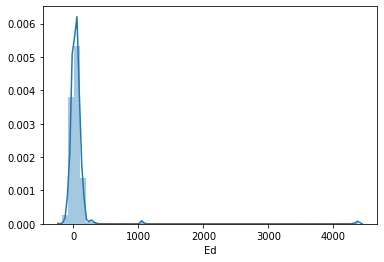

In [118]:
sns.distplot(dfSii['Ed'])

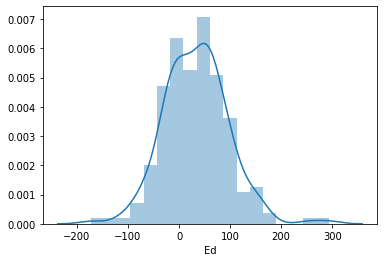

In [119]:
msd=(dfSii['Ed']<1000)
sns.distplot(dfSii[msd]['Ed'])

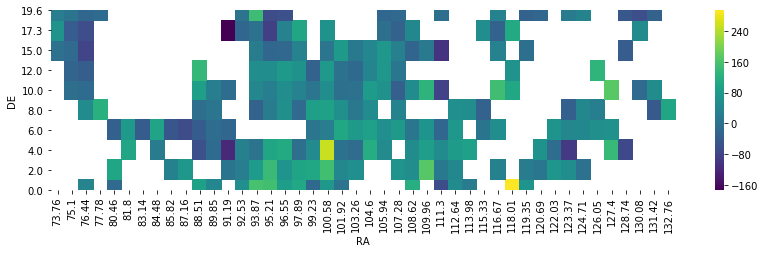

In [120]:
dataS_d=(dfSii[msd].round(2)).pivot(index='DE', columns='RA', values='Ed')
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataS_d, cmap="viridis")
plt.gca().invert_yaxis()


#Blue arm

In [179]:
input_file='datosNGC604a.txt'

data_0B=pd.read_table(input_file)
data=data_0B.copy()
data_2B=(data.round(2)).pivot(index='DE', columns='RA', values='[OIII]5007')

In [122]:
data.describe()

,RA,DE,Hbeta,RVHbeta,SigmHbeta,[OIII]4959,RV[OIII]4959,Sigm[OIII]4959,[OIII]5007,RV[OIII]5007,Sigm[OIII]5007
count,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1.333000e+03,1333.000000,1333.000000,1.333000e+03,1333.000000,1333.000000
mean,108.007532,9.351613,37.157464,-309.293008,230.467592,-7.379595e+16,249.178597,550.280848,-2.213803e+17,224.584914,544.304119
std,61.956092,6.596011,273.525984,781.898267,1558.331837,2.694310e+18,5654.075888,3148.490294,8.082657e+18,5598.754562,3117.782689
min,1.430000,0.000000,-1915.000000,-19921.950000,0.000000,-9.837000e+19,-4875.320000,0.000000,-2.951000e+20,-4849.770000,0.000000
25%,54.360000,4.000000,-4.700000,-315.890000,3.880000,-1.890000e+00,-324.580000,9.580000,-5.670000e+00,-343.550000,6.900000
50%,108.710000,8.000000,5.490000,-239.910000,23.100000,8.900000e-01,-292.420000,27.080000,2.660000e+00,-311.700000,25.990000
75%,161.640000,15.000000,23.690000,-207.780000,61.560000,7.440000e+00,-189.710000,71.020000,2.232000e+01,-210.000000,70.020000
max,214.560000,19.600000,6126.000000,2234.470000,31720.860000,5.941000e+09,129082.250000,48095.580000,1.782000e+10,127797.120000,47625.000000


/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-9.231694900576741, 225.22169490057675, -0.987998770755577, 20.58799877075558)

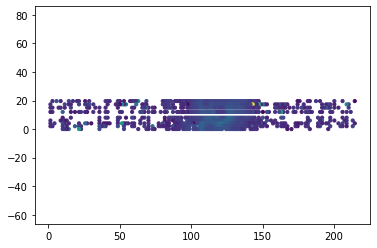

In [123]:
plt.scatter(data.RA,data.DE,c=np.log10(data['[OIII]5007']), s=10)
plt.axis('equal')

In [124]:
m=(data.RA<145)&(data.RA>100)
dataB=data[m]
dataB.describe()

,RA,DE,Hbeta,RVHbeta,SigmHbeta,[OIII]4959,RV[OIII]4959,Sigm[OIII]4959,[OIII]5007,RV[OIII]5007,Sigm[OIII]5007
count,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,288.000000,288.000000,2.880000e+02,288.000000,288.000000
mean,122.299375,9.322222,97.501076,-248.563125,132.133299,2.062853e+07,-304.059653,180.412535,6.187517e+07,-323.238437,177.643611
std,13.230577,6.596931,122.441404,230.524279,829.739197,3.500768e+08,197.955299,1590.080810,1.050054e+09,196.019375,1574.624044
min,100.130000,0.000000,0.000000,-3778.580000,0.000000,-4.000000e+00,-2670.800000,0.000000,-1.199000e+01,-2666.820000,0.000000
25%,111.212500,4.000000,28.942500,-243.945000,15.420000,1.169500e+01,-309.357500,16.270000,3.509250e+01,-328.485000,14.740000
50%,122.295000,8.000000,54.405000,-235.035000,19.550000,2.496000e+01,-302.060000,20.795000,7.487500e+01,-321.250000,19.545000
75%,133.387500,15.000000,121.200000,-227.107500,26.387500,5.966500e+01,-294.470000,27.397500,1.790250e+02,-313.740000,26.320000
max,144.470000,19.600000,823.900000,931.940000,9053.850000,5.941000e+09,2004.110000,19852.040000,1.782000e+10,1962.360000,19657.800000


#[OIII] emission line analysis

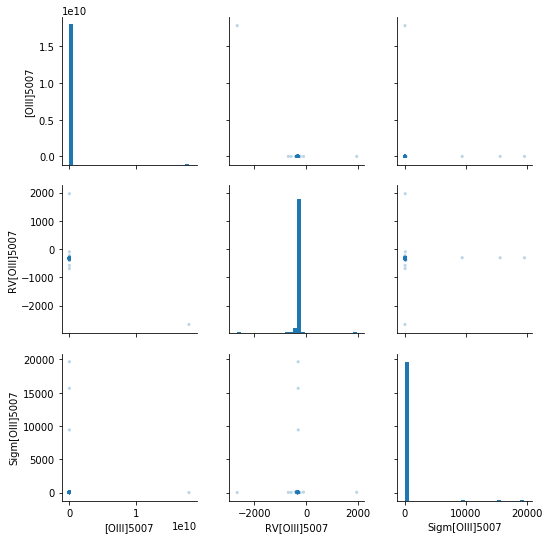

In [125]:
sns.pairplot(dataB,
             vars=["[OIII]5007", "RV[OIII]5007", "Sigm[OIII]5007"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

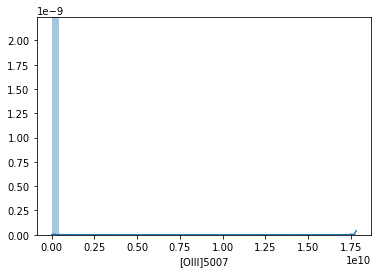

In [126]:
sns.distplot(dataB['[OIII]5007'], bins=40)

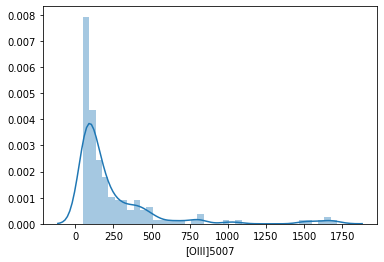

In [127]:
mhb=(dataB['[OIII]5007']<10000)&(dataB['[OIII]5007']>50)
sns.distplot(dataB[mhb]['[OIII]5007'],bins=40)

(99.47225558498825,
 145.12774441501173,
 -1.0011627582134726,
 20.601162758213476)

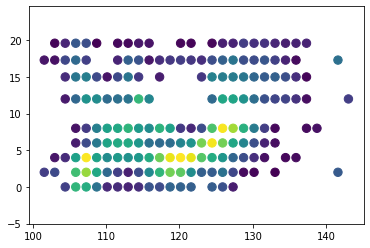

In [128]:
plt.scatter(dataB[mhb].RA,dataB[mhb].DE,c=np.log10(dataB[mhb]['[OIII]5007']), s=70)
plt.axis('equal')

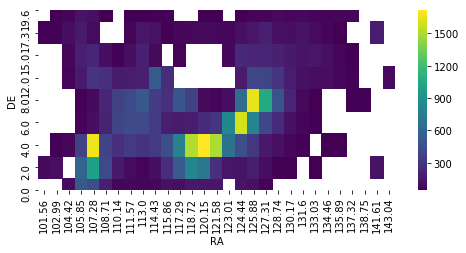

In [129]:
dataB=dataB[mhb]
dataB_f=(dataB.round(2)).pivot(index='DE', columns='RA', values='[OIII]5007')
fig, ax = plt.subplots(figsize=(8, 3.3))
sns.heatmap(dataB_f, cmap="viridis")
plt.gca().invert_yaxis()

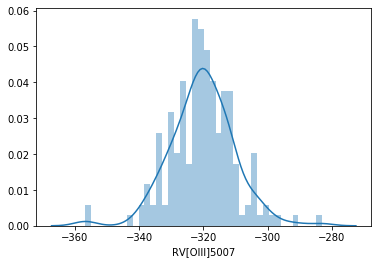

In [130]:
sns.distplot(dataB['RV[OIII]5007'], bins=40)

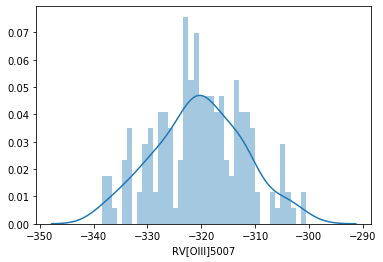

In [131]:
mbrv=(dataB['RV[OIII]5007']>-340)&(dataB['RV[OIII]5007']<-300)
sns.distplot(dataB[mbrv]['RV[OIII]5007'], bins=40)

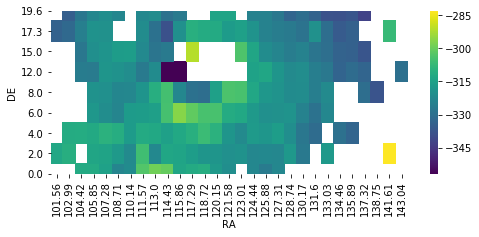

In [132]:
dataB_rv=(dataB.round(2)).pivot(index='DE', columns='RA', values='RV[OIII]5007')
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(dataB_rv, cmap="viridis")
plt.gca().invert_yaxis()

In [133]:
a=[dataB[mbrv].RA,dataB[mbrv].DE,dataB[mbrv]['RV[OIII]5007']]
dataOstat=pd.DataFrame(a).T
dataOstat.columns=['X','Y','RV']
dataOstat.describe()

,X,Y,RV
count,181.000000,181.000000,181.000000
mean,119.750608,9.570166,-320.363481
std,10.232093,6.540353,8.277964
min,101.560000,0.000000,-338.520000
25%,111.570000,4.000000,-326.370000
50%,120.150000,8.000000,-320.560000
75%,128.740000,15.000000,-314.400000
max,143.040000,19.600000,-300.570000


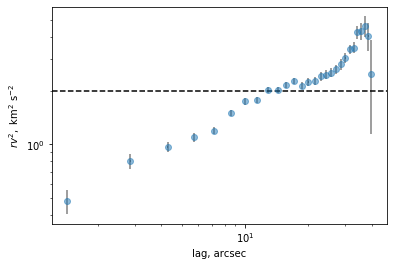

In [134]:
sf_o=sosfnorm(dataOstat)

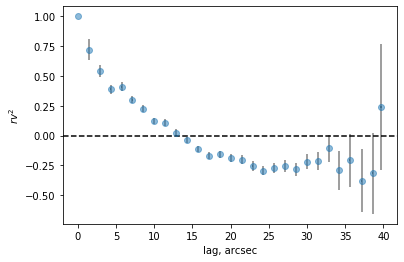

In [135]:
af_o=acf(dataOstat)

In [136]:
mOO=(data_0B.RA<137)&(data_0B.RA>100)
dataOO=data_0B[mOO]
dataOO.describe()

,RA,DE,Hbeta,RVHbeta,SigmHbeta,[OIII]4959,RV[OIII]4959,Sigm[OIII]4959,[OIII]5007,RV[OIII]5007,Sigm[OIII]5007
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,118.008077,9.322222,112.384658,-247.782521,115.841197,67.237821,-300.475427,215.663761,201.713718,-319.689103,212.543077
std,10.751691,6.599585,121.920563,232.107438,809.870271,97.284595,10.138844,1762.794336,291.855599,10.042024,1745.658496
min,100.130000,0.000000,0.000000,-3778.580000,0.000000,-1.350000,-337.880000,0.000000,-4.040000,-356.720000,0.000000
25%,108.710000,4.000000,39.770000,-239.597500,15.710000,17.687500,-306.605000,16.620000,53.052500,-325.755000,15.100000
50%,118.005000,8.000000,69.040000,-232.970000,19.190000,32.835000,-300.790000,21.000000,98.505000,-320.000000,19.760000
75%,127.310000,15.000000,141.000000,-226.475000,25.607500,72.400000,-294.215000,27.140000,217.175000,-313.485000,26.060000
max,135.890000,19.600000,823.900000,-163.560000,9053.850000,571.800000,-268.360000,19852.040000,1715.000000,-287.880000,19657.800000


In [137]:
a=[dataOO.RA,dataOO.DE,dataOO['RV[OIII]5007']]
dataOOstat=pd.DataFrame(a).T
dataOOstat.columns=['X','Y','RV']
dataOOstat.describe()

,X,Y,RV
count,234.000000,234.000000,234.000000
mean,118.008077,9.322222,-319.689103
std,10.751691,6.599585,10.042024
min,100.130000,0.000000,-356.720000
25%,108.710000,4.000000,-325.755000
50%,118.005000,8.000000,-320.000000
75%,127.310000,15.000000,-313.485000
max,135.890000,19.600000,-287.880000


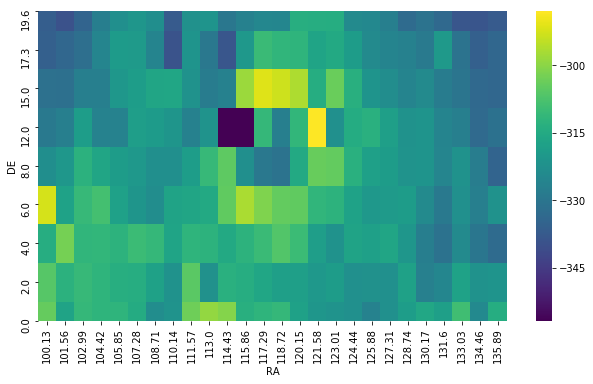

In [138]:
dataOO_rv=(dataOO.round(2)).pivot(index='DE', columns='RA', values='RV[OIII]5007')
fig, ax = plt.subplots(figsize=(10.5, 5.7))
sns.heatmap(dataOO_rv, cmap="viridis")
plt.gca().invert_yaxis()
#plt.axis('equal')

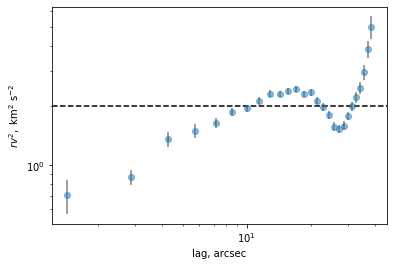

In [139]:
sfn_O2=sosfnorm(dataOOstat)

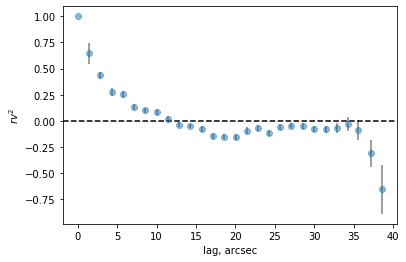

In [140]:
af_O2=acf(dataOOstat)

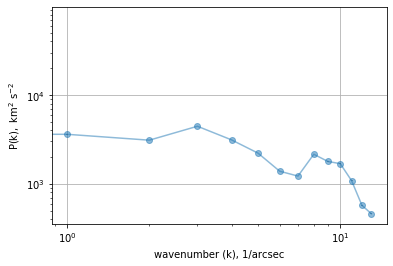

In [141]:
ps_O2=ps(dataOOstat)

#Lines comparison

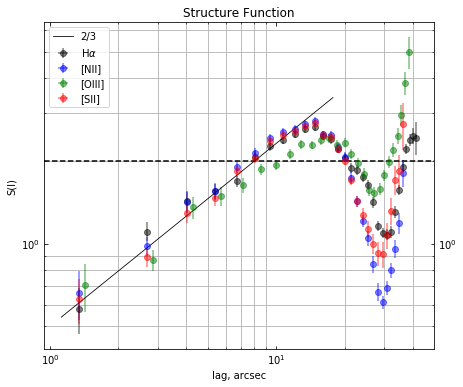

In [142]:
fig, ax=plt.subplots(figsize=(7,6))
ax.errorbar(sfn_h3['Lag'],sfn_h3['Nmqvd'],xerr=sfn_h3.ErrX,yerr=sfn_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5, label=r'H$\alpha$')
ax.errorbar(sfn_n2['Lag'],sfn_n2['Nmqvd'],xerr=sfn_n2.ErrX,yerr=sfn_n2.ErrY, fmt="o",color='b', ecolor='b', alpha=0.5, label='[NII]')
ax.errorbar(sfn_O2['Lag'],sfn_O2['Nmqvd'],xerr=sfn_O2.ErrX,yerr=sfn_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
ax.errorbar(sfn_s2['Lag'],sfn_s2['Nmqvd'],xerr=sfn_s2.ErrX,yerr=sfn_s2.ErrY, fmt="o",color='r', ecolor='r', alpha=0.5, label='[SII]')
ax.set(xscale='log',yscale='log')
sgrid = np.logspace(.05, 1.25)
ax.plot(sgrid, 0.5*sgrid**(2/3), color="k", lw=0.8, label='2/3')
ax.axhline(y=2, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='S(l)')
plt.title('Structure Function')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.legend(loc='upper left')
plt.grid(which='minor')

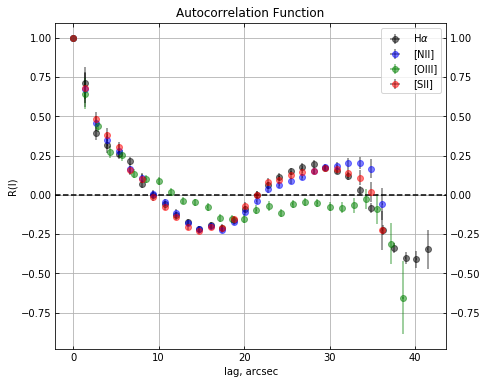

In [143]:
fig, ax=plt.subplots(figsize=(7,6))
ax.errorbar(af_h3['Lag'],af_h3['Nmqvd'],xerr=af_h3.ErrX,yerr=af_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5,label=r'H$\alpha$')
ax.errorbar(af_n2['Lag'],af_n2['Nmqvd'],xerr=af_n2.ErrX,yerr=af_n2.ErrY, fmt="o",color='b', ecolor='k', alpha=0.5,label='[NII]')
ax.errorbar(af_O2['Lag'],af_O2['Nmqvd'],xerr=af_O2.ErrX,yerr=af_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
ax.errorbar(af_s2['Lag'],af_s2['Nmqvd'],xerr=af_s2.ErrX,yerr=af_s2.ErrY, fmt="o",color='r', ecolor='k', alpha=0.5,label='[SII]')
#x.set(xscale='log')
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='R(l)')
plt.title('Autocorrelation Function')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.legend()
plt.grid()


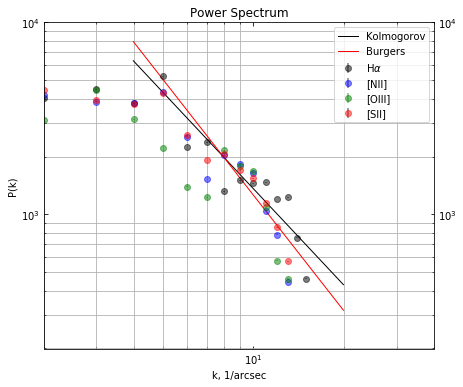

In [144]:
fig, ax=plt.subplots(figsize=(7,6))
ax.errorbar(ps_h3['k'],ps_h3['P(k)'], yerr=ps_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5,label=r'H$\alpha$')
ax.errorbar(ps_n2['k'],ps_n2['P(k)'], yerr=ps_n2.ErrY, fmt="o",color='b', ecolor='k', alpha=0.5,label='[NII]')
ax.errorbar(ps_O2['k'],ps_O2['P(k)'], yerr=ps_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
ax.errorbar(ps_s2['k'],ps_s2['P(k)'], yerr=ps_s2.ErrY, fmt="o",color='r', ecolor='k', alpha=0.5,label='[SII]')
ax.set(xscale='log', yscale='log')
sgrid = np.logspace(0.6, 1.3)
plt.plot(sgrid, (10**4.8)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov")
plt.plot(sgrid, (10**5.1)*sgrid**(-2), color="r", lw=1, label="Burgers")
ax.set(xlabel='k, 1/arcsec', ylabel='P(k)')
plt.title('Power Spectrum')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
ax.set(xlim=[2, 40],ylim=[200, 10000])
plt.legend()
plt.grid(which='minor')

#Intensity weighted analysis

In [159]:
argo=(dataHH.Halpha*dataHH.RVHalpha)/dataHH.Halpha.max()

In [160]:
dfav = pd.DataFrame({'X': dataHH.RA, 'Y': dataHH.DE, 'RV': argo})
dfav.describe()

,X,Y,RV
count,300.00000,300.000000,300.000000
mean,105.26850,9.390000,-35.656101
std,11.62634,6.261276,41.845649
min,85.82400,0.000000,-279.062188
25%,95.21100,4.000000,-43.383732
50%,105.26850,9.000000,-20.047018
75%,115.32600,15.000000,-11.240681
max,124.71300,19.600000,-1.986063


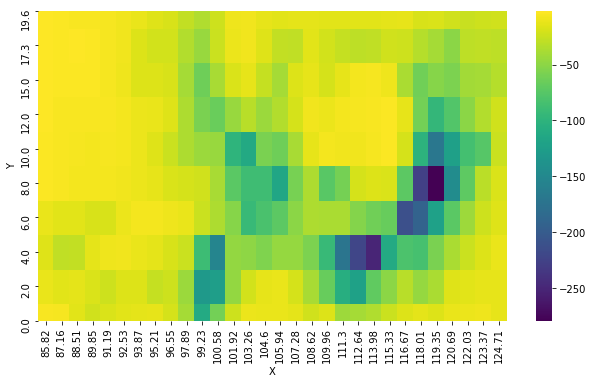

In [147]:
dataO1_rv=(dfav.round(2)).pivot(index='Y', columns='X', values='RV')
fig, ax = plt.subplots(figsize=(10.5, 5.7))
sns.heatmap(dataO1_rv, cmap="viridis")
plt.gca().invert_yaxis()
#plt.axis('equal')

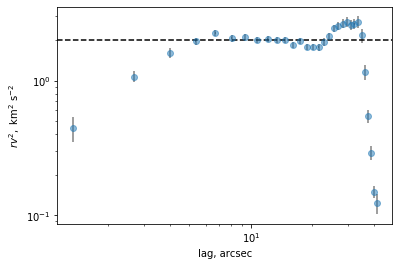

In [148]:
sfn_Hav=sosfnorm(dfav)

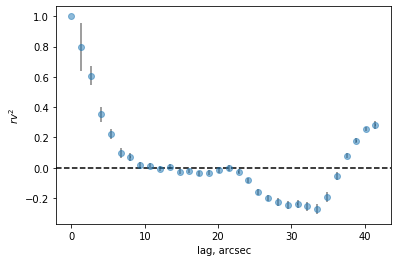

In [149]:
ac_Hav=acf(dfav)

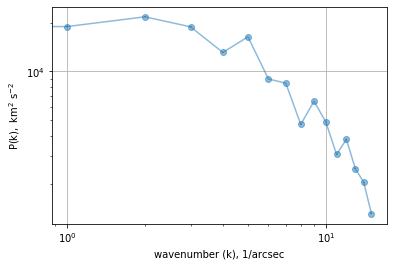

In [150]:
ps_Hav=ps(dfav)

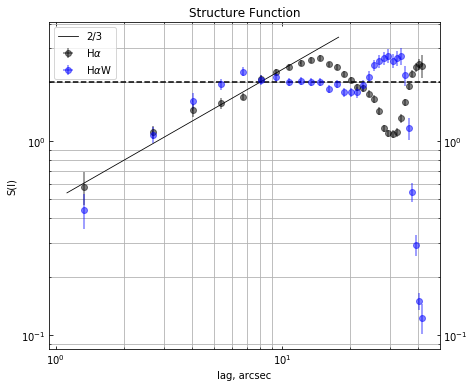

In [151]:
fig, ax=plt.subplots(figsize=(7,6))
ax.errorbar(sfn_h3['Lag'],sfn_h3['Nmqvd'],xerr=sfn_h3.ErrX,yerr=sfn_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5, label=r'H$\alpha$')
ax.errorbar(sfn_Hav['Lag'],sfn_Hav['Nmqvd'],xerr=sfn_Hav.ErrX,yerr=sfn_Hav.ErrY, fmt="o",color='b', ecolor='b', alpha=0.5, label=r'H$\alpha$W')
#ax.errorbar(sfn_O2['Lag'],sfn_O2['Nmqvd'],xerr=sfn_O2.ErrX,yerr=sfn_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
#ax.errorbar(sfn_s2['Lag'],sfn_s2['Nmqvd'],xerr=sfn_s2.ErrX,yerr=sfn_s2.ErrY, fmt="o",color='r', ecolor='r', alpha=0.5, label='[SII]')
ax.set(xscale='log',yscale='log')
sgrid = np.logspace(.05, 1.25)
ax.plot(sgrid, 0.5*sgrid**(2/3), color="k", lw=0.8, label='2/3')
ax.axhline(y=2, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='S(l)')
plt.title('Structure Function')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.legend(loc='upper left')
plt.grid(which='minor')

In [162]:
argo=(dataHH.Halpha*dataHH.RVHalpha)/np.sum(dataHH.Halpha)

In [163]:
dfav = pd.DataFrame({'X': dataHH.RA, 'Y': dataHH.DE, 'RV': argo})
dfav.describe()

,X,Y,RV
count,300.00000,300.000000,300.000000
mean,105.26850,9.390000,-0.920285
std,11.62634,6.261276,1.080037
min,85.82400,0.000000,-7.202602
25%,95.21100,4.000000,-1.119735
50%,105.26850,9.000000,-0.517414
75%,115.32600,15.000000,-0.290122
max,124.71300,19.600000,-0.051260


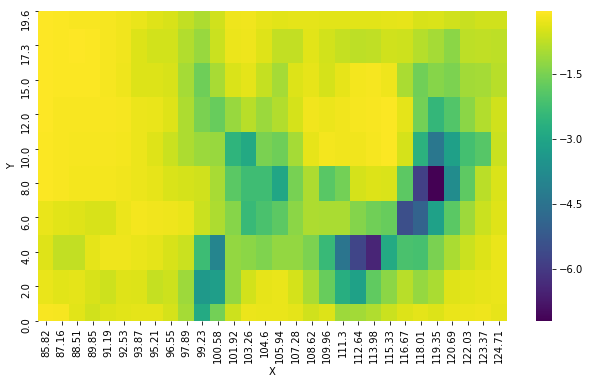

In [164]:
dataO1_rv=(dfav.round(2)).pivot(index='Y', columns='X', values='RV')
fig, ax = plt.subplots(figsize=(10.5, 5.7))
sns.heatmap(dataO1_rv, cmap="viridis")
plt.gca().invert_yaxis()
#plt.axis('equal')

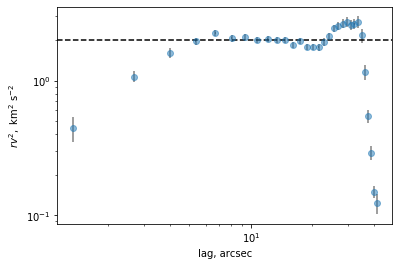

In [165]:
sfn_Hav=sosfnorm(dfav)

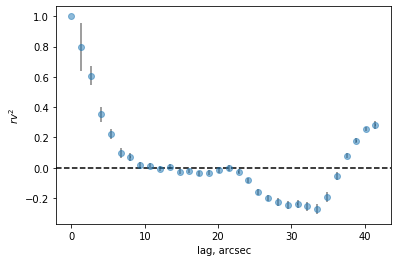

In [166]:
ac_Hav=acf(dfav)

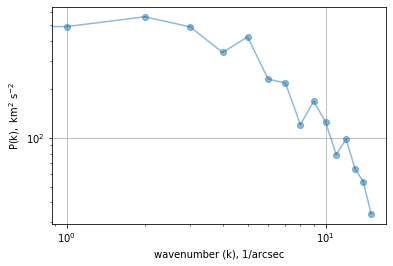

In [167]:
ps_Hav=ps(dfav)

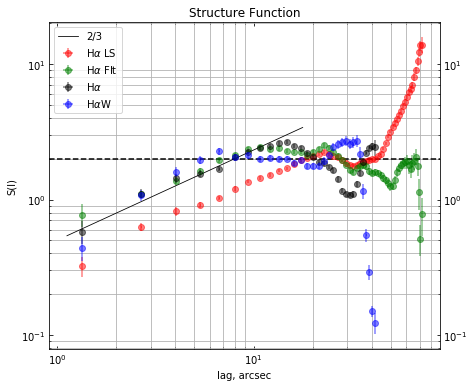

In [177]:
fig, ax=plt.subplots(figsize=(7,6))
ax.errorbar(sfn_h['Lag'],sfn_h['Nmqvd'],xerr=sfn_h.ErrX, yerr=sfn_h.ErrY, fmt="o",color='r', ecolor='r', alpha=0.5, label=r'H$\alpha$ LS')
ax.errorbar(sfn_h2['Lag'],sfn_h2['Nmqvd'],xerr=sfn_h2.ErrX,yerr=sfn_h2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label=r'H$\alpha$ Flt')
ax.errorbar(sfn_h3['Lag'],sfn_h3['Nmqvd'],xerr=sfn_h3.ErrX,yerr=sfn_h3.ErrY, fmt="o",color='k', ecolor='k', alpha=0.5, label=r'H$\alpha$')
ax.errorbar(sfn_Hav['Lag'],sfn_Hav['Nmqvd'],xerr=sfn_Hav.ErrX,yerr=sfn_Hav.ErrY, fmt="o",color='b', ecolor='b', alpha=0.5, label=r'H$\alpha$W')
#ax.errorbar(sfn_O2['Lag'],sfn_O2['Nmqvd'],xerr=sfn_O2.ErrX,yerr=sfn_O2.ErrY, fmt="o",color='g', ecolor='g', alpha=0.5, label='[OIII]')
#ax.errorbar(sfn_s2['Lag'],sfn_s2['Nmqvd'],xerr=sfn_s2.ErrX,yerr=sfn_s2.ErrY, fmt="o",color='r', ecolor='r', alpha=0.5, label='[SII]')
ax.set(xscale='log',yscale='log')
sgrid = np.logspace(.05, 1.25)
ax.plot(sgrid, 0.5*sgrid**(2/3), color="k", lw=0.8, label='2/3')
ax.axhline(y=2, color='k', linestyle='--')
ax.set(xlabel='lag, arcsec', ylabel='S(l)')
plt.title('Structure Function')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.legend(loc='upper left')
plt.grid(which='minor')